In [88]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [89]:
import os


zip_file_name = 'Assignment5.zip'


extracted_dir = 'Assignment5'


if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)


os.system(f'unzip {zip_file_name} -d {extracted_dir}')

print("Data extracted successfully.")

Data extracted successfully.


In [91]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets

# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/Assignment5/Assignment5'


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Create a ResNet model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer to match number of classes
num_classes = len(class_names)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# Train the model for a specified number of epochs
train_model(model, criterion, optimizer, num_epochs=25)




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0/24
----------
train Loss: 0.4283 Acc: 0.7561
val Loss: 0.0669 Acc: 1.0000
Epoch 1/24
----------
train Loss: 0.4710 Acc: 0.7805
val Loss: 0.0149 Acc: 1.0000
Epoch 2/24
----------
train Loss: 0.6553 Acc: 0.8354
val Loss: 0.0063 Acc: 1.0000
Epoch 3/24
----------
train Loss: 0.3541 Acc: 0.9268
val Loss: 0.0235 Acc: 1.0000
Epoch 4/24
----------
train Loss: 0.2451 Acc: 0.9146
val Loss: 0.0202 Acc: 1.0000
Epoch 5/24
----------
train Loss: 0.2505 Acc: 0.8902
val Loss: 0.0654 Acc: 0.9500
Epoch 6/24
----------
train Loss: 0.3544 Acc: 0.8720
val Loss: 0.0580 Acc: 1.0000
Epoch 7/24
----------
train Loss: 0.3712 Acc: 0.8659
val Loss: 0.0599 Acc: 0.9500
Epoch 8/24
----------
train Loss: 0.1091 Acc: 0.9512
val Loss: 0.2453 Acc: 0.9500
Epoch 9/24
----------
train Loss: 0.2776 Acc: 0.9329
val Loss: 0.0386 Acc: 1.0000
Epoch 10/24
----------
train Loss: 0.1618 Acc: 0.9390
val Loss: 0.0196 Acc: 1.0000
Epoch 11/24
----------
train Loss: 0.2361 Acc: 0.9207
val Loss: 0.1821 Acc: 0.8500
Epoch 12/24
--

In [92]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from PIL import Image

# Define data transformation for validation
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/Assignment5/Assignment5'
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=data_transforms)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model.to(device)
model.eval()

# Function to classify an image and get class index and confidence score
def classify_image(image):
    image = data_transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.softmax(outputs, dim=1)[0][predicted[0]].item()
        return predicted[0], confidence

# Classify validation images and print the results
for image_path, class_idx in val_dataset.samples:
    image = Image.open(image_path)  # Load the image using PIL
    class_index, confidence = classify_image(image)
    print(f"Image: {image_path}")
    print(f"Class Index: {class_index}, Confidence: {confidence:.4f}")






Image: /content/Assignment5/Assignment5/val/with fire/500.jpg
Class Index: 974, Confidence: 0.1843
Image: /content/Assignment5/Assignment5/val/with fire/501.jpg
Class Index: 980, Confidence: 0.4867
Image: /content/Assignment5/Assignment5/val/with fire/502.jpg
Class Index: 980, Confidence: 0.9746
Image: /content/Assignment5/Assignment5/val/with fire/503.jpg
Class Index: 980, Confidence: 0.9580
Image: /content/Assignment5/Assignment5/val/with fire/504.jpg
Class Index: 980, Confidence: 0.7452
Image: /content/Assignment5/Assignment5/val/with fire/505.jpg
Class Index: 980, Confidence: 0.7972
Image: /content/Assignment5/Assignment5/val/with fire/506.jpg
Class Index: 980, Confidence: 0.7234
Image: /content/Assignment5/Assignment5/val/with fire/507.jpg
Class Index: 895, Confidence: 0.7146
Image: /content/Assignment5/Assignment5/val/with fire/508.jpg
Class Index: 980, Confidence: 0.2403
Image: /content/Assignment5/Assignment5/val/with fire/509.jpg
Class Index: 980, Confidence: 0.9718
Image: /co

Epoch 1, Loss: 0.4655, Train Accuracy: 76.83%, Validation Accuracy: 95.00%
Epoch 2, Loss: 0.2677, Train Accuracy: 90.24%, Validation Accuracy: 100.00%
Epoch 3, Loss: 0.1946, Train Accuracy: 92.07%, Validation Accuracy: 95.00%
Epoch 4, Loss: 0.3462, Train Accuracy: 89.63%, Validation Accuracy: 100.00%
Epoch 5, Loss: 0.2502, Train Accuracy: 89.02%, Validation Accuracy: 100.00%
Epoch 6, Loss: 0.4560, Train Accuracy: 86.59%, Validation Accuracy: 95.00%
Epoch 7, Loss: 0.2489, Train Accuracy: 91.46%, Validation Accuracy: 100.00%
Epoch 8, Loss: 0.3650, Train Accuracy: 89.63%, Validation Accuracy: 95.00%
Epoch 9, Loss: 0.2657, Train Accuracy: 90.85%, Validation Accuracy: 100.00%
Epoch 10, Loss: 0.3667, Train Accuracy: 87.20%, Validation Accuracy: 100.00%


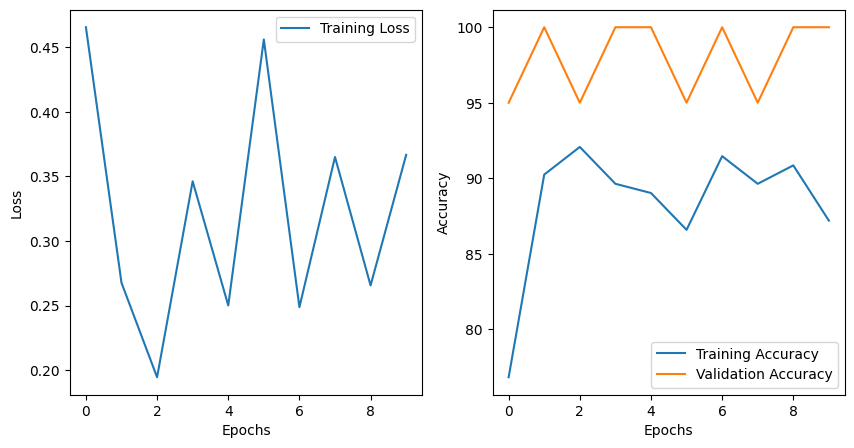

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/Assignment5/Assignment5'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Load a pre-trained ResNet model
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Lists to store training results for plotting
train_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    correct = 0
    total = 0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(dataloaders['train'])
    train_accuracy = 100 * correct / total

    # Evaluation on the validation set
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

# Save the trained model
torch.save(model.state_dict(), 'fire_detection_model.pth')

# Plot learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
